### Create the figure for the manual classification

In [1]:
import altair as alt
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys

sys.path.insert(0, "../src_clean")
from utils import Loader
l = Loader()

### Load the data

In [2]:
# V2 error data
error_data = pd.read_csv("../data/clean_errors_data.csv", dtype={'user_id':str})

# Final annotations based on majority labels
finalized_annotations = pd.read_parquet("../data/FINAL_ANNOTATIONS.parquet")

# Accounts with any political affiliation
final_political_only = finalized_annotations[finalized_annotations['political_affiliation'] != 'n/a'].copy()
final_political_only.loc[:,'label'] = 'any political affiliation'

# Follower count data
fcounts = pd.read_csv(
    "../data/correlation_rts_removed_w_followers_count.csv",
    index_col=0,
    dtype={'user_ids':str}
)[["user_ids","followers_count"]]

In [3]:
error_data

,user_id,status,twitter_error
0,1204429316219691008,User has been suspended,https://api.twitter.com/2/problems/resource-no...
1,1229861495326093312,User has been suspended,https://api.twitter.com/2/problems/resource-no...
2,1211401123275296770,Could not find user with ids,https://api.twitter.com/2/problems/resource-no...
3,2994893355,User has been suspended,https://api.twitter.com/2/problems/resource-no...
4,1083180973276229632,User has been suspended,https://api.twitter.com/2/problems/resource-no...
...,...,...,...
14090,1096479510046953473,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14091,176406752,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14092,39115118,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14093,1187142124980068353,User has been suspended,https://api.twitter.com/2/problems/resource-no...


In [4]:
l.load_user_data(name="v2",info_type="errors")

,user_id,status,twitter_error
0,1204429316219691008,User has been suspended,https://api.twitter.com/2/problems/resource-no...
1,1229861495326093312,User has been suspended,https://api.twitter.com/2/problems/resource-no...
2,1211401123275296770,Could not find user with ids,https://api.twitter.com/2/problems/resource-no...
3,2994893355,User has been suspended,https://api.twitter.com/2/problems/resource-no...
4,1083180973276229632,User has been suspended,https://api.twitter.com/2/problems/resource-no...
...,...,...,...
14090,1096479510046953473,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14091,176406752,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14092,39115118,User has been suspended,https://api.twitter.com/2/problems/resource-no...
14093,1187142124980068353,User has been suspended,https://api.twitter.com/2/problems/resource-no...


In [5]:
finalized_annotations

,user_id,classification,political_affiliation
0,861186587144577025,not active,n/a
1,1134618385495527425,other,n/a
2,875017115979403264,not active,n/a
3,1199522589573554176,not active,n/a
4,864934909961523200,not active,n/a
...,...,...,...
227,16269666,media outlet,n/a
228,73928096,organization,n/a
229,594886554,political,right
230,375721095,media outlet,n/a


### Number/percent of non-active that were suspended

In [6]:
not_active = finalized_annotations[finalized_annotations.classification == "not active"]

val_counts = pd.merge(
    not_active,
    error_data,
    on='user_id'
)['status'].value_counts()

num_suspended = val_counts['User has been suspended'] 
print(f"Number of non-active accounts suspended: {num_suspended}")
print(f"Proportion non-active suspended: {num_suspended/len(not_active)}")

Number of non-active accounts suspended: 111
Proportion non-active suspended: 0.8671875


### Load the top FIBers and influential users and calculate the proportion from each that have been suspended

In [7]:
top_fibers = l.load_iffyp_ss()[['user_id']]
num_top_users = len(top_fibers)
top_fibers['type'] ='fib'

top_inf = l.load_iffyp_baseline(
    name="influential"
).head(num_top_users)[
    ['original_tweeter_user_id']
].rename(columns={'original_tweeter_user_id':'user_id'})
top_inf['type'] ='inf'

top_fib_and_inf = pd.concat([top_fibers, top_inf])

In [8]:
top_fib_and_inf

,user_id,type
0,4765364386,fib
1,3530404094,fib
2,41634520,fib
3,232901331,fib
4,2981776113,fib
...,...,...
176,915231714724712448,inf
177,11454572,inf
178,1037648264672079872,inf
179,806347865073315844,inf


In [9]:
worst_w_errors = error_data.merge(top_fib_and_inf, on='user_id')
worst_w_suspensions = worst_w_errors[
    worst_w_errors.status == "User has been suspended"
]

counts = worst_w_suspensions.type.value_counts()


print(f"Values:\n{counts}")


props = counts / num_top_users
print(f"Proportions:\n{props}")


Values:
fib    86
inf    78
Name: type, dtype: int64
Proportions:
fib    0.475138
inf    0.430939
Name: type, dtype: float64


### Count and proportion of each category for only the activate accounts

In [10]:
finalized_annotations[
    finalized_annotations['classification'] != "not active"
]['classification'].value_counts()

political       54
other           14
media outlet    12
media aff.       7
intellectual     5
new media        4
organization     4
pub. service     2
broad. news      1
hard news        1
Name: classification, dtype: int64

In [11]:
active = finalized_annotations[
    finalized_annotations['classification'] != "not active"
]

active['classification'].value_counts(normalize=True) * 100

political       51.923077
other           13.461538
media outlet    11.538462
media aff.       6.730769
intellectual     4.807692
new media        3.846154
organization     3.846154
pub. service     1.923077
broad. news      0.961538
hard news        0.961538
Name: classification, dtype: float64

### Calculate the median number of followers for the `other` group

In [12]:
other_only = finalized_annotations[finalized_annotations.classification == "other"].copy()
other_only.head()

,user_id,classification,political_affiliation
1,1134618385495527425,other,n/a
12,1018425398869282817,other,n/a
27,1274690550,other,n/a
64,1071493866489044993,other,n/a
96,94120026,other,n/a


In [13]:
# merge users with the follower count dataframe
other_w_fcounts = pd.merge(
    other_only,
    fcounts,
    left_on="user_id",
    right_on="user_ids"
)

# Ensure we have the same number of users
assert len(other_only) == len(other_w_fcounts), "Missing users!"

# In the paper we round up to an even 14k
other_w_fcounts.followers_count.median()

13774.766691013363

### Calculate the proportion of accounts that are "media related"

In [14]:
media_related = finalized_annotations[
    finalized_annotations.classification.isin(['media aff.', 'media outlet'])
].copy()

num_media = len(media_related)
num_active = len(active)

print(f"Number of media related: {num_media}")
print(f"Proportion of active that are media related: {num_media/num_active}")
print(f"Percent of active that are media related: {num_media/num_active:%}")

Number of media related: 19
Proportion of active that are media related: 0.18269230769230768
Percent of active that are media related: 18.269231%


### Calculate the number/proportion of accounts that are left/right for those categorized as `political`

In [15]:
pol_only = finalized_annotations[
    finalized_annotations.classification == 'political'
].copy()
pol_only.head()

,user_id,classification,political_affiliation
6,3314383418,political,right
13,2176476241,political,right
23,186562905,political,right
25,1494835716,political,right
26,4765364386,political,right


In [16]:
pol_only.political_affiliation.value_counts()

right    49
left      5
Name: political_affiliation, dtype: int64

In [17]:
pol_only.political_affiliation.value_counts(normalize=True)

right    0.907407
left     0.092593
Name: political_affiliation, dtype: float64

### Calculate the number/proportion of accounts that are left/right for any category with any political affiliation

As a reminder, we do the below earlier in the notebook to create the `final_political_only` frame.
```py
final_political_only = finalized_annotations[finalized_annotations['political_affiliation'] != 'n/a'].copy()
final_political_only.loc[:,'label'] = 'any political affiliation'
```

In [18]:
final_political_only.political_affiliation.value_counts()

right    63
left      6
Name: political_affiliation, dtype: int64

In [19]:
final_political_only.political_affiliation.value_counts(normalize=True)

right    0.913043
left     0.086957
Name: political_affiliation, dtype: float64

### Create the figure

In [20]:
leaning_count = final_political_only['political_affiliation'].value_counts().to_frame("count")

In [21]:
# Calculate the counts for each classification and political affiliation
counts = finalized_annotations.groupby(['classification', 'political_affiliation']).size().unstack(fill_value=0)

# Sort the DataFrame by the total count across all political affiliations in descending order
counts = counts.assign(total=counts.sum(axis=1)).sort_values('total', ascending=True)

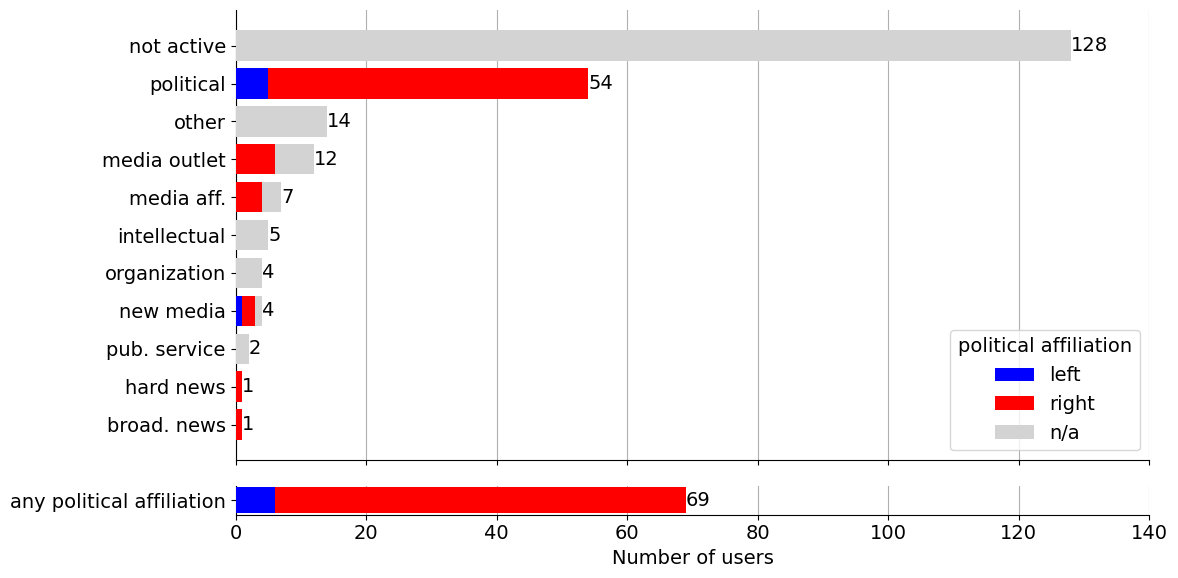

In [22]:
mpl.rcParams['font.size'] = 14

# Create a figure
fig = plt.figure(figsize=(12, 6))

# Define the grid layout
gs = gridspec.GridSpec(2, 1, height_ratios=[.94,.06])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])


### Top Figure

# Add for left
ax1.barh(
    y = counts.index,
    width = counts['left'],
    color = 'blue',
    label = 'left',
    zorder=3,
    
)

# Add for right
ax1.barh(
    y = counts.index,
    width = counts['right'],
    left = counts['left'],
    color = 'red',
    label = 'right',
    zorder=3
)

# Add for n/a
ax1.barh(
    y = counts.index,
    width = counts['n/a'],
    left = counts['left'] + counts['right'],
    color = 'lightgrey',
    label = 'n/a',
    zorder=3
)

# Add text annotations
for idx, data in counts.reset_index().iterrows():
    ax1.text(
        x = data.total,
        y = data.classification,
        s = str(data.total),
        va='center',
        zorder=3
    )


### Bottom Figure

ax2.barh(
    y = 'any political affiliation',
    width = leaning_count.loc["left"].item(),
    color='blue',
    left=0,
    zorder=3
)

ax2.barh(
    y = 'any political affiliation',
    width = leaning_count.loc["right"].item(),
    color='red',
    left=leaning_count.loc["left"].item(),
    zorder=3
)

ax2.text(
    x = leaning_count.loc["left"].item() + leaning_count.loc["right"].item(),
    y = 'any political affiliation',
    s = str(leaning_count.loc["left"].item() + leaning_count.loc["right"].item()),
    va='center'
)

### Make everything pretty

# Add legend
ax1.legend(title = "political affiliation", loc='lower right')

# Add x-axis grid
ax1.grid(axis='x',zorder=0)
ax2.grid(axis='x',zorder=0)

# Remove the borders from both
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Set xlimits
ax1.set_xlim(0,140)
ax2.set_xlim(0,140)

# Make x-axis pretty
ax1.set_xticklabels([])
ax2.set_xlabel("Number of users")

plt.tight_layout()

fig.savefig(
    "../figures/aggregate_classification.pdf",
    bbox_inches='tight',
    dpi = 600
)